In [1]:
import torch
from torch import nn
import cv2
import random
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import tqdm
from torchvision import datasets, transforms
import wandb
from torch.utils.data import DataLoader
from sklearn.preprocessing import Normalizer

In [2]:
df = pd.read_csv('./raisins/Raisin_Dataset.csv')

In [3]:
len(df)

900

In [4]:
df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,Extent,Perimeter,Class
0,87524,442.246011,253.291155,0.819738,90546,0.758651,1184.040,Kecimen
1,75166,406.690687,243.032436,0.801805,78789,0.684130,1121.786,Kecimen
2,90856,442.267048,266.328318,0.798354,93717,0.637613,1208.575,Kecimen
3,45928,286.540559,208.760042,0.684989,47336,0.699599,844.162,Kecimen
4,79408,352.190770,290.827533,0.564011,81463,0.792772,1073.251,Kecimen


In [5]:
# df.drop(columns=['Id'], inplace=True)

In [6]:
label_encoder = LabelEncoder()

In [7]:
df['Class'] = label_encoder.fit_transform(df['Class'])
# df['Species'] = label_encoder.fit_transform(df['Species'])

In [8]:
X = torch.from_numpy(df.iloc[:450, :df.shape[1] -1].to_numpy())
Y = torch.from_numpy(df.iloc[:450, df.shape[1] -1].to_numpy())

In [9]:
normalizer = Normalizer()
X = torch.from_numpy(normalizer.fit_transform(X))

In [10]:
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid(),
        )
        
    def forward(self, x):
        return self.fc(x)


class Generator(nn.Module):

    def __init__(self, z_dim, output_dim):
        super().__init__()
        self.generator = nn.Sequential(
            nn.Linear(z_dim, out_features=128),
            nn.LeakyReLU(),
            nn.Linear(in_features=128, out_features=256),
            nn.LeakyReLU(),
            nn.Linear(in_features=256, out_features=128),
            nn.LeakyReLU(),
            nn.Linear(in_features=128, out_features=output_dim),
        )

    def forward(self, x):
        x = self.generator(x)
        return x
        

In [11]:
feature_vector_len = 7
z_dim = 100

dn = Discriminator(input_dim=feature_vector_len)
gn = Generator(z_dim=z_dim, output_dim=feature_vector_len)

In [12]:
loss_fn = nn.BCELoss()
d_optimizer = torch.optim.Adam(dn.parameters(), lr=6e-4)
g_optimizer = torch.optim.Adam(gn.parameters(), lr=6e-4)

In [13]:
random_data = torch.rand(X.shape[0], z_dim)



truth_labels = torch.ones_like(random_data[:, 0])
fake_labels = torch.zeros_like(random_data[:, 0])

In [14]:
real_data = X.float()

real_data.shape


torch.Size([450, 7])

In [15]:
epochs = 30000

for _ in range(epochs):

    if _ < 5000:
        d_optimizer.zero_grad()
        
        outputs = dn(real_data).view(-1)
        d_loss_truth = loss_fn(outputs, truth_labels)
        
        random_data = torch.rand(X.shape[0], z_dim)
        fake_data = gn(random_data).float()
        outputs = dn(fake_data).view(-1)
        d_loss_fake = loss_fn(outputs, fake_labels)
        
        d_loss = d_loss_truth + d_loss_fake
        
        d_loss.backward()
        d_optimizer.step()
        
    # training generator
    g_optimizer.zero_grad()
    random_data = torch.rand(X.shape[0], z_dim)
    fake_data = gn(random_data).float()
    
    outputs = dn(fake_data).view(-1)
    g_loss = loss_fn(outputs, truth_labels)
    g_loss.backward()
    g_optimizer.step()

    print(f'Epoch {_ + 1} ; g_loss {g_loss} ; d_loss {d_loss} ')





Epoch 1 ; g_loss 0.7709742784500122 ; d_loss 1.3961644172668457 
Epoch 2 ; g_loss 0.7669764757156372 ; d_loss 1.3690897226333618 
Epoch 3 ; g_loss 0.7604491710662842 ; d_loss 1.348052740097046 
Epoch 4 ; g_loss 0.7528197765350342 ; d_loss 1.3322789669036865 
Epoch 5 ; g_loss 0.7433987855911255 ; d_loss 1.3180909156799316 
Epoch 6 ; g_loss 0.7318207621574402 ; d_loss 1.3075159788131714 
Epoch 7 ; g_loss 0.7168483734130859 ; d_loss 1.3007657527923584 
Epoch 8 ; g_loss 0.698315441608429 ; d_loss 1.2999076843261719 
Epoch 9 ; g_loss 0.6750035285949707 ; d_loss 1.307049036026001 
Epoch 10 ; g_loss 0.6482899785041809 ; d_loss 1.3220093250274658 
Epoch 11 ; g_loss 0.6212074756622314 ; d_loss 1.3434244394302368 
Epoch 12 ; g_loss 0.5969188213348389 ; d_loss 1.3686344623565674 
Epoch 13 ; g_loss 0.5748645663261414 ; d_loss 1.3985340595245361 
Epoch 14 ; g_loss 0.5575490593910217 ; d_loss 1.430501937866211 
Epoch 15 ; g_loss 0.5424252152442932 ; d_loss 1.4625871181488037 
Epoch 16 ; g_loss 0.531

In [16]:
generated_data = gn(random_data)

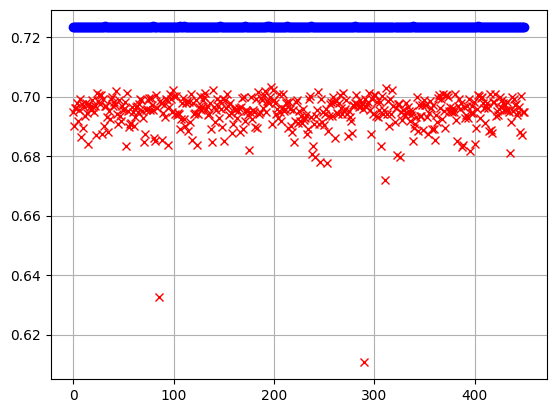

In [17]:
plt.grid()
plt.plot(generated_data[:, 0].detach().numpy(), 'bo')
plt.plot(X[:, 0].detach().numpy(), 'rx')

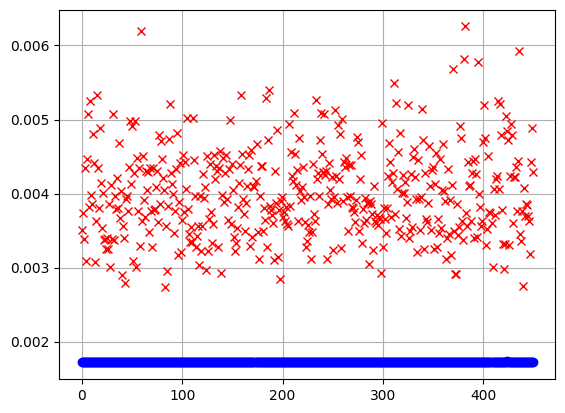

In [18]:
plt.grid()
plt.plot(generated_data[:, 1].detach().numpy(), 'bo')
plt.plot(X[:, 1].detach().numpy(), 'rx')

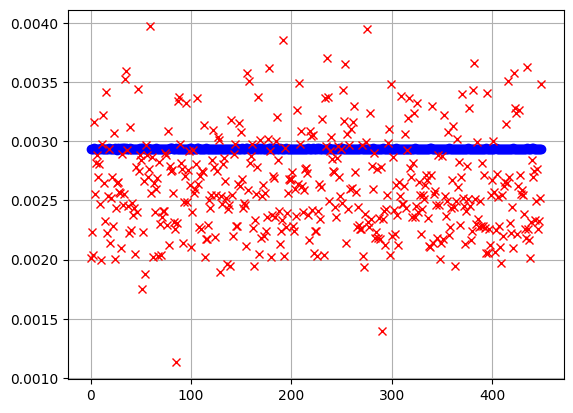

In [19]:
plt.grid()
plt.plot(generated_data[:, 2].detach().numpy(), 'bo')
plt.plot(X[:, 2].detach().numpy(), 'rx')

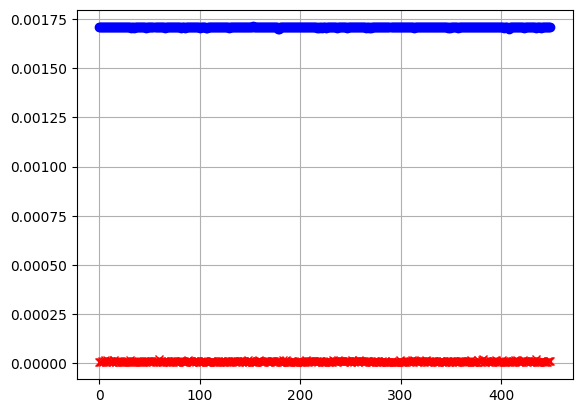

In [20]:
plt.grid()
plt.plot(generated_data[:, 3].detach().numpy(), 'bo')
plt.plot(X[:, 3].detach().numpy(), 'rx')

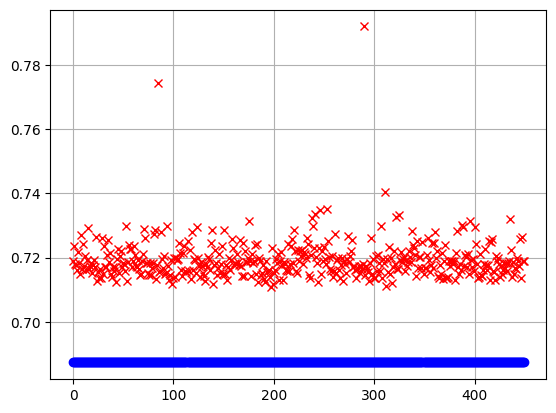

In [21]:
plt.grid()
plt.plot(generated_data[:, 4].detach().numpy(), 'bo')
plt.plot(X[:, 4].detach().numpy(), 'rx')

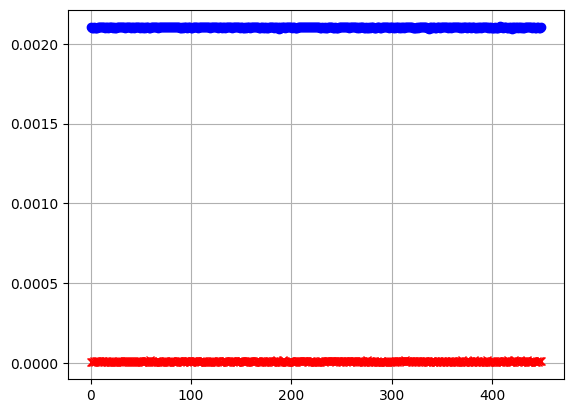

In [22]:
plt.grid()
plt.plot(generated_data[:, 5].detach().numpy(), 'bo')
plt.plot(X[:, 5].detach().numpy(), 'rx')

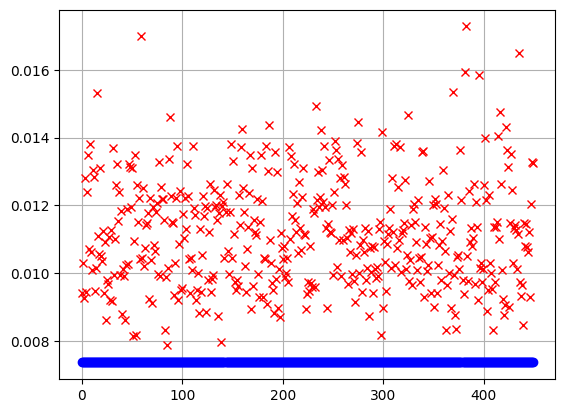

In [23]:
plt.grid()
plt.plot(generated_data[:, 6].detach().numpy(), 'bo')
plt.plot(X[:, 6].detach().numpy(), 'rx')